# Fit halo mass to shear profile: 1. ideal data

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass of a galaxy cluster in the ideal case: i) all galaxies on a single source plane, ii) no redshift errors, iii) no shape noise. The steps below correspond to:
- Setting things up, with the proper imports.
- Generating an ideal mock dataset.
- Computing the binned reduced tangential shear profile for two different binning scheme.
- Setting up the model to be fitted to the data.
- Perform a simple fit using NumCosmo tools to compute the best-fit and the Fisher Matrix, and visualize the results.

Note that this notebook is equivalent to `Example1_Fit_Halo_Mass_to_Shear_Catalog.ipynb` except for the statistical analysis, where here we use some NumCosmo tools.

## Setup

First, we import some standard packages.

In [1]:
# For NumCosmo
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [2]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import numpy as np
import matplotlib.pyplot as plt

from numpy import random

Next, we import `clmm`'s core modules.

In [3]:
import clmm
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology

Make sure we know which version we're using

In [4]:
clmm.__version__

'0.8.0'

We then import support modules for a specific data set.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.
We also provide support modules for processing other specific data sets for use with `clmm`.
Any existing support module can be used as a template for creating a new support module for another data set.
If you do make such a support module, please do consider making a pull request so we can add it for others to use.

## Making mock data

In [5]:
from clmm.support import mock_data as mock

In [6]:
np.random.seed(11)

To create mock data, we need to define a true cosmology.

In [7]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

We now set some parameters for a mock galaxy cluster.

In [8]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15 # M200,m [Msun]
cluster_z = 0.3   # Cluster's redshift
src_z = 0.8       # Background galaxies' redshifts (single source plane) 
concentration = 4
ngals = 10000     # Number of galaxies
cluster_ra = 0.0
cluster_dec = 0.0

Then we use the `mock_data` support module to generate a new galaxy catalog.

In [9]:
ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration,
                                          cosmo, src_z, ngals=ngals)

This galaxy catalog is then converted to a `clmm.GalaxyCluster` object.

In [10]:
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data)

A `clmm.GalaxyCluster` object can be pickled and saved for later use.

In [11]:
gc_object.save('mock_GC.pkl')

Any saved `clmm.GalaxyCluster` object may be read in for analysis.

In [12]:
cl = clmm.GalaxyCluster.load('mock_GC.pkl')
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra, "; dec:", cl.dec,
      "; z_l :", cl.z)
print("The number of source galaxies is :", len(cl.galcat))

# Lens position and redshift
ra_l = cl.ra
dec_l = cl.dec
z = cl.z
# Galaxies: ellipticities, position (RA, DEC), redshift 
e1 = cl.galcat['e1']
e2 = cl.galcat['e2']
ra_s = cl.galcat['ra']
dec_s = cl.galcat['dec']
z_s = cl.galcat['z']

Cluster info = ID: Awesome_cluster ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 10000


We can visualize the distribution of galaxies on the sky.

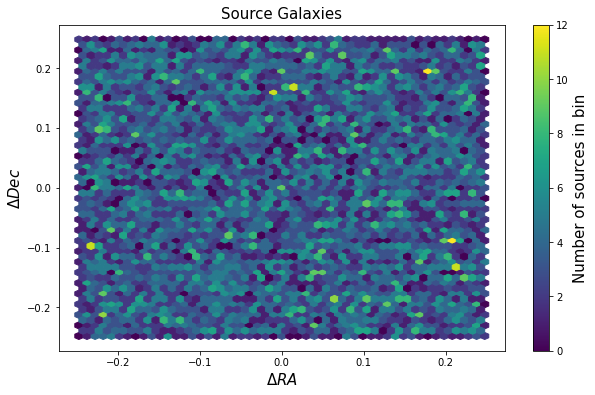

In [13]:
fsize = 15

fig = plt.figure(figsize=(10, 6))
hb = fig.gca().hexbin(ra_s, dec_s, gridsize=50)

cb = fig.colorbar(hb)
cb.set_label('Number of sources in bin', fontsize=fsize)

plt.gca().set_xlabel(r'$\Delta RA$', fontsize=fsize)
plt.gca().set_ylabel(r'$\Delta Dec$', fontsize=fsize)
plt.gca().set_title('Source Galaxies', fontsize=fsize)

plt.show()

`clmm` separates cosmology-dependent and cosmology-independent functionality.

## Deriving observables

We first demonstrate a few of the procedures one can perform on data without assuming a cosmology.

### Computing shear

`clmm.dataops.compute_tangential_and_cross_components` calculates the tangential and cross shears for each source galaxy in the cluster.

In [14]:
theta, g_t, g_x = da.compute_tangential_and_cross_components(ra_l, dec_l, ra_s, dec_s, e1, e2, geometry="flat")

We can visualize the shear field at each galaxy location.

Text(0.5, 0, 'angular distance [rad]')

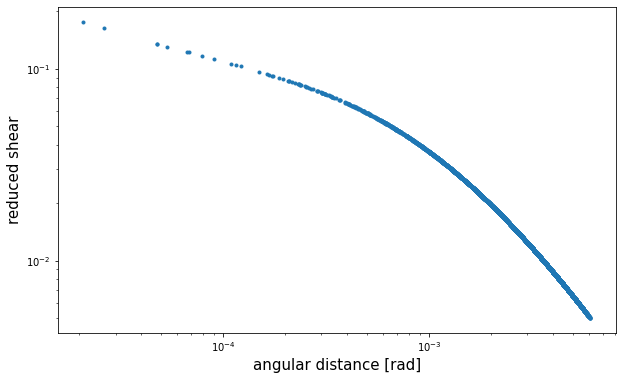

In [15]:
fig = plt.figure(figsize=(10, 6))

fig.gca().loglog(theta, g_t, '.')
plt.ylabel("reduced shear", fontsize=fsize)
plt.xlabel("angular distance [rad]", fontsize=fsize)

### Radially binning the data

Here we compare the reconstructed mass under two different bin definitions. 

Note binning would cause fitted mass to be slightly larger than input mass. The reason is that g(r), the tangential reduced shear along cluster radius, is a convex function -- the function value after binning would be larger, but the bias becomes smaller as bin number increases.

In [16]:
bin_edges1 = da.make_bins(0.01, 3.7, 50)
bin_edges2 = da.make_bins(0.01, 3.7, 10)

`clmm.dataops.make_radial_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [17]:
res1 = da.make_radial_profile(
    [g_t, g_x, z_s], theta, "radians", "Mpc", bins=bin_edges1, cosmo=cosmo, z_lens=z, include_empty_bins=False)
res2 = da.make_radial_profile(
    [g_t, g_x, z_s], theta, "radians", "Mpc", bins=bin_edges2, cosmo=cosmo, z_lens=z, include_empty_bins=False)

Note that we set `include_empty_bins=False` explicitly here even though it is the default behavior. Setting the argument to `True` would also return empty bins (that is, bins with *at most one* data point in them), which would have to be excluded manually when fitting, though it might be useful e.g., when combining datasets. To clarify the behavior, consider the following comparison:

In [18]:
res_with_empty = da.make_radial_profile(
    [g_t, g_x, z_s], theta, "radians", "Mpc", bins=1000, cosmo=cosmo, z_lens=z, include_empty_bins=True)
# this is the default behavior
res_without_empty = da.make_radial_profile(
    [g_t, g_x, z_s], theta, "radians", "Mpc", bins=1000, cosmo=cosmo, z_lens=z, include_empty_bins=False)
res_with_empty['n_src'].size, res_without_empty['n_src'].size

(1000, 892)

i.e., 108 bins have fewer than two sources in them and are excluded by default (when setting the random seed to 11).

For later use, we'll define some variables for the binned radius and tangential shear.

In [19]:
gt_profile1 = res1['p_0']
r1 = res1['radius']
z1 = res1['p_2']

gt_profile2 = res2['p_0']
r2 = res2['radius']
z2 = res2['p_2']

We visualize the radially binned shear for our mock galaxies.

Text(0, 0.5, '$g_t$')

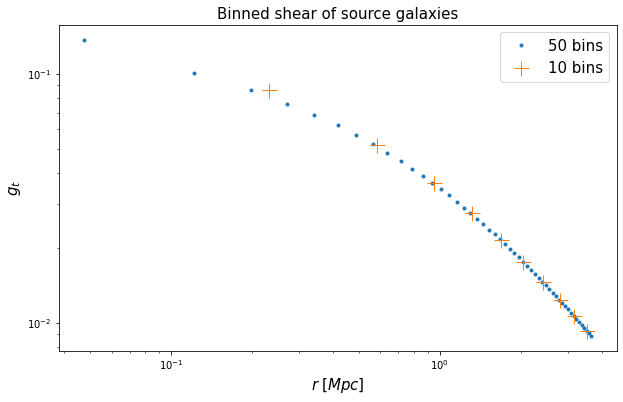

In [20]:
fig = plt.figure(figsize=(10, 6))

fig.gca().loglog(r1, gt_profile1, '.', label='50 bins')
fig.gca().loglog(r2, gt_profile2, '+', markersize=15, label='10 bins')
plt.legend(fontsize=fsize)

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;[Mpc]$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)

You can also run `make_radial_profile` direct on a `clmm.GalaxyCluster` object.

In [21]:
cl.compute_tangential_and_cross_components() # You need to add the shear components first
cl.make_radial_profile("Mpc", bins=1000, cosmo=cosmo, include_empty_bins=False)
pass

After running `clmm.GalaxyCluster.make_radial_profile` object, the object acquires the `clmm.GalaxyCluster.profile` attribute.

In [22]:
for n in cl.profile.colnames: cl.profile[n].format = "%6.3e"
cl.profile.pprint(max_width=-1)

radius_min   radius  radius_max     gt      gt_err      gx       gx_err      z       z_err     n_src  
---------- --------- ---------- --------- --------- ---------- --------- --------- --------- ---------
 1.929e-02 2.182e-02  2.490e-02 1.691e-01 4.808e-03  2.168e-19 1.533e-19 8.000e-01 0.000e+00 2.000e+00
 4.172e-02 4.415e-02  4.733e-02 1.349e-01 7.322e-05  0.000e+00 9.813e-18 8.000e-01 0.000e+00 2.000e+00
 5.855e-02 6.252e-02  6.416e-02 1.220e-01 2.593e-04 -6.939e-18 0.000e+00 8.000e-01 0.000e+00 2.000e+00
 1.595e-01 1.611e-01  1.651e-01 9.199e-02 7.327e-05  4.684e-17 3.067e-17 8.000e-01 0.000e+00 2.000e+00
 1.931e-01 1.937e-01  1.987e-01 8.635e-02 3.066e-05  1.735e-17 1.227e-17 8.000e-01 0.000e+00 2.000e+00
 2.100e-01 2.141e-01  2.156e-01 8.328e-02 9.241e-05 -1.735e-18 1.227e-18 8.000e-01 0.000e+00 2.000e+00
 2.156e-01 2.186e-01  2.212e-01 8.263e-02 1.109e-04 -2.313e-18 1.889e-18 8.000e-01 6.410e-17 3.000e+00
 2.324e-01 2.357e-01  2.380e-01 8.029e-02 8.050e-05 -1.247e-17 3.910e-18 

## Modeling the data

We next demonstrate a few of the procedures one can perform once a cosmology has been chosen.

### Choosing a halo model

Here we model using the OO inteface, we also use NumCosmo statistical framework to perform the analysis. Below we create an object based on NumCosmo NcmDataGaussDiag (Gaussian likelihood with a diagonal covariance matrix) object. To connect with the C interface the object must implement the methods: `do_get_length`, `do_get_dof`, `do_begin`, `do_prepare` and `do_mean_func`. The last method is responsible to compute the theoretical predictions. In the param_set_ftype calls below one can change between FREE/FIXED to include/exclude the parameter from the analysis.

In [23]:
class GaussGammaT (Ncm.DataGaussDiag):
    z_cluster = GObject.Property (type = float, flags = GObject.PARAM_READWRITE)
    z_source  = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)
    r_source  = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)
    
    def __init__ (self, z_cluster, r_source, z_source, gt_profile, moo = None):
        Ncm.DataGaussDiag.__init__ (self, n_points = len (gt_profile))
        
        self.moo = moo if moo else clmm.Modeling ()
        
        assert len (gt_profile) == len (z_source)
        assert len (gt_profile) == len (r_source)
        
        self.set_size (len (gt_profile))
        
        self.props.z_cluster = z_cluster
        self.props.z_source  = Ncm.Vector.new_array (z_source)
        self.props.r_source  = Ncm.Vector.new_array (r_source)
        
        self.y.set_array (gt_profile)
        
        self.sigma.set_all (1.0e-2) # Diagonal covariance matrix: all points have the same standard deviation value
        
        self.set_init (True)
    
    # Once the NcmDataGaussDiag is initialized, its parent class variable np is set with the n_points value. 
    def do_get_length (self):
        return self.np

    def do_get_dof (self):
        return self.np

    def do_begin (self):
        pass

    def do_prepare (self, mset):
        self.moo.set_mset (mset)
        
    def do_mean_func (self, mset, vp):
        vp.set_array (self.moo.eval_reduced_shear (self.props.r_source.dup_array (), self.props.z_cluster, self.props.z_source.dup_array ()))
        return

GObject.type_register (GaussGammaT)


NcContext.GaussGammaT

Defining the model set (NcmMset), data set (NcmDataset) and NcmLikelihood objects to carry out a statistical analysis. 

The method `param_set_ftype` defines the parameters that can be fitted: `mid` - to which model set the parameter belongs to, `pid` - parameters' id, NcmParamType (FREE or FIXED) to say if the parameter will be fitted or not.

In [24]:
moo1 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo1.set_cosmo (cosmo)
moo1.set_concentration (4.0)

moo2 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo2.set_cosmo (cosmo)
moo2.set_concentration (4.0)

ggt1 = GaussGammaT (z_cluster = cluster_z, r_source = r1, z_source = z1, gt_profile = gt_profile1, moo = moo1)
ggt2 = GaussGammaT (z_cluster = cluster_z, r_source = r2, z_source = z2, gt_profile = gt_profile2, moo = moo2)

mset1 = ggt1.moo.get_mset ()
mset2 = ggt2.moo.get_mset ()

#Parameters: cluster mass (log base 10) and concentration
log10MDelta_pi = mset1.param_get_by_full_name ("NcHaloDensityProfile:log10MDelta")
cDelta_pi      = mset1.param_get_by_full_name ("NcHaloDensityProfile:cDelta")
  
mset1.param_set_ftype (log10MDelta_pi.mid, log10MDelta_pi.pid, Ncm.ParamType.FREE)
mset1.param_set_ftype (cDelta_pi.mid,      cDelta_pi.pid,      Ncm.ParamType.FIXED)
mset1.prepare_fparam_map ()

mset2.param_set_ftype (log10MDelta_pi.mid, log10MDelta_pi.pid, Ncm.ParamType.FREE)
mset2.param_set_ftype (cDelta_pi.mid,      cDelta_pi.pid,      Ncm.ParamType.FIXED)
mset2.prepare_fparam_map ()

dset1 = Ncm.Dataset.new ()
dset1.append_data (ggt1)
lh1 = Ncm.Likelihood.new (dset1)

dset2 = Ncm.Dataset.new ()
dset2.append_data (ggt2)
lh2 = Ncm.Likelihood.new (dset2)


### Fitting parameters: Fisher Matrix

The NcmFit object receives the NcmLikelihood and NcmMset objects. The user also indicates the fitting algorithm and the numerical differentiation method.  
Functions `run` and `fisher` computes the best-fit and the fisher matrix, respectively. `log_info` prints the complete information about the data used, models and its parameters, and `log_covar` prints the best-fit along with the error-bar and the covariance matrix.

In [25]:
fit1 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh1, mset1, Ncm.FitGradType.NUMDIFF_FORWARD)
fit2 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh2, mset2, Ncm.FitGradType.NUMDIFF_FORWARD)

fit1.run (Ncm.FitRunMsgs.SIMPLE)
fit1.fisher ()
fit1.log_info ()
fit1.log_covar ()

fit2.run (Ncm.FitRunMsgs.SIMPLE)
fit2.fisher ()
fit2.log_info ()
fit2.log_covar ()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#...........
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0040710
#  iteration            [000026]
#  function evaluations [000028]
#  gradient evaluations [000000]
#  degrees of freedom   [000049]
#  m2lnL     =    0.192639131613735 (    0.19263913 )
#  Fit parameters:
#     15.0081833159765    
#----------------------------------------------------------------------------------
# Data used:
#   - NcContext+GaussGammaT
#----------------------------------------------------------------------------------
# Model[01000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -          H0[00]:  70                 

Next, we calculate the reduced tangential shear predicted by the two models.

In [26]:
rr = np.logspace(-2, np.log10(5), 100)

gt_model1 = moo1.eval_reduced_shear (rr, cluster_z, src_z)
gt_model2 = moo2.eval_reduced_shear (rr, cluster_z, src_z)

m_est1 = 10**(mset1.param_get (log10MDelta_pi.mid, log10MDelta_pi.pid))
m_est2 = 10**(mset2.param_get (log10MDelta_pi.mid, log10MDelta_pi.pid))

print ("mest1 % 22.15g mest2 % 22.15g" % (m_est1, m_est2))

mest1   1.01902142687901e+15 mest2   1.06051618375666e+15


We visualize the two predictions of reduced tangential shear.

Text(0, 0.5, 'reduced tangential shear')

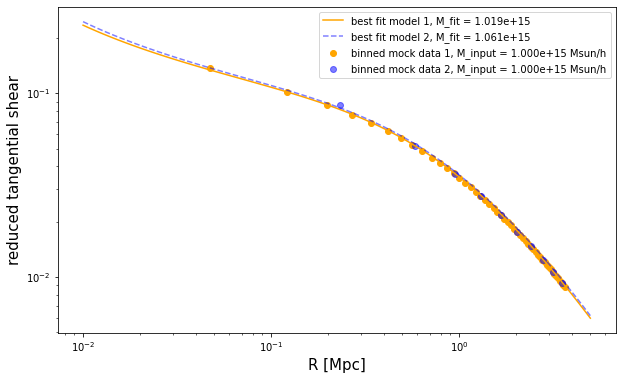

In [27]:
fig = plt.figure(figsize=(10, 6))

fig.gca().scatter(r1, gt_profile1, color='orange',
                  label='binned mock data 1, M_input = %.3e Msun/h' % cluster_m)
fig.gca().plot(rr, gt_model1, color='orange',
               label='best fit model 1, M_fit = %.3e' % m_est1)

fig.gca().scatter(r2, gt_profile2, color='blue', alpha=0.5,
                  label='binned mock data 2, M_input = %.3e Msun/h' % cluster_m)
fig.gca().plot(rr, gt_model2, color='blue', linestyle='--', alpha=0.5,
               label='best fit model 2, M_fit = %.3e' % m_est2)

plt.semilogx()
plt.semilogy()

plt.legend()
plt.xlabel('R [Mpc]', fontsize=fsize)
plt.ylabel('reduced tangential shear', fontsize=fsize)